# Python OCR
- 파이썬에서 사용되는 OCR 라이브러리들 테스트 하기

## OCR 라이브러리
> - paddleocr
> - pytesseract
> - CRAFT

## CRAFT
https://github.com/clovaai/CRAFT-pytorch/blob/master/test.py



In [3]:
import sqlite3
import json
import time
import re
from uuid import getnode
import socket
import io
import os
import cv2
import base64
import numpy as np
from PIL import Image
from paddleocr import PaddleOCR, draw_ocr
from matplotlib import pyplot as plt
import pandas as pd

In [4]:
os.getcwd()

'c:\\leeyeonjun\\gitRepository\\leeyeonjun85.github.io.git\\assets\\source\\CRAFT-pytorch-master'

In [1]:
import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile
from collections import OrderedDict
from craft import CRAFT

c:\Users\uurang\.conda\envs\UU3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

net = CRAFT()     # initialize
trained_model = 'C:/leeyeonjun/gitRepository/leeyeonjun85.github.io.git/assets/source/CRAFT-pytorch-master/weights/craft_mlt_25k.pth'
net.load_state_dict(copyStateDict(torch.load(trained_model, map_location='cpu')))

canvas_size = 1280
mag_ratio = 1.5
show_time = False
text_threshold = 0.7
link_threshold = 0.4
low_text = 0.4
cuda = False
poly = False

c:\Users\uurang\.conda\envs\UU3\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
c:\Users\uurang\.conda\envs\UU3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\uurang\.conda\envs\UU3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
def get_files(img_dir):
    imgs, masks, xmls = list_files(img_dir)
    return imgs, masks, xmls

def list_files(in_path):
    img_files = []
    mask_files = []
    gt_files = []
    for (dirpath, dirnames, filenames) in os.walk(in_path):
        for file in filenames:
            filename, ext = os.path.splitext(file)
            ext = str.lower(ext)
            if ext == '.jpg' or ext == '.jpeg' or ext == '.gif' or ext == '.png' or ext == '.pgm':
                img_files.append(os.path.join(dirpath, file))
            elif ext == '.bmp':
                mask_files.append(os.path.join(dirpath, file))
            elif ext == '.xml' or ext == '.gt' or ext == '.txt':
                gt_files.append(os.path.join(dirpath, file))
            elif ext == '.zip':
                continue
    # img_files.sort()
    # mask_files.sort()
    # gt_files.sort()
    return img_files, mask_files, gt_files

def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    if show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text


In [5]:
imgPath = 'C:/leeyeonjun/gitRepository/leeyeonjun85.github.io.git/assets/source/CRAFT-pytorch-master/img'
image_list, _, _ = get_files(imgPath)
result_folder = 'C:/leeyeonjun/gitRepository/leeyeonjun85.github.io.git/assets/source/CRAFT-pytorch-master/result'

In [28]:
net.eval()

# load data
for k, image_path in enumerate(image_list):
    print("Test image {:d}/{:d}: {:s}".format(k+1, len(image_list), image_path), end='\r')
    image = imgproc.loadImage(image_path)

    bboxes, polys, score_text = test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly)

    # save score text
    filename, file_ext = os.path.splitext(os.path.basename(image_path))
    mask_file = result_folder + "/res_" + filename + '_mask.jpg'
    cv2.imwrite(mask_file, score_text)

    file_utils.saveResult(image_path, image[:,:,::-1], polys, dirname=result_folder)

print("elapsed time : {}s".format(time.time() - time.time()))

elapsed time : 0.0sleeyeonjun/gitRepository/leeyeonjun85.github.io.git/assets/source/CRAFT-pytorch-master/img\sqlite-sample-database-color.jpg0px.png


In [19]:
image_path = 'C:/leeyeonjun/gitRepository/leeyeonjun85.github.io.git/assets/source/CRAFT-pytorch-master/img/KakaoTalk_20240402_131936278.png'
# image_path = 'C:/leeyeonjun/gitRepository/leeyeonjun85.github.io.git/assets/source/CRAFT-pytorch-master/img/testBmp1.bmp'
image = imgproc.loadImage(image_path)

bboxes, polys, score_text = test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly)

In [13]:
filename, file_ext = os.path.splitext(os.path.basename(image_path))
mask_file = result_folder + "/res_" + filename + '_mask.jpg'
cv2.imwrite(mask_file, score_text)

True

In [16]:
from paddleocr import PaddleOCR, draw_ocr
from matplotlib import pyplot as plt

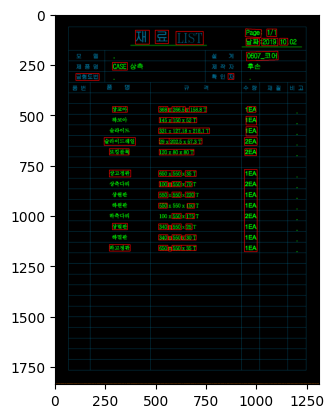

In [20]:
ocrImageArray = draw_ocr(image, bboxes)
ocrImage = Image.fromarray(ocrImageArray)
imgplot = plt.imshow(ocrImage)
plt.imshow(ocrImage)